In [1]:
import sys
sys.path.insert(0, "./")

from preference_data import *
from reward_model import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from buildings_factory import *
import pickle


# buildings_list = ["ApartmentsThermal-v0", "ApartmentsGrid-v0", "Apartments2Thermal-v0",
#                   "Apartments2Grid-v0", "OfficesThermostat-v0", "MixedUseFanFCU-v0",
#                   "SeminarcenterThermostat-v0", "SeminarcenterFull-v0", "SimpleHouseRad-v0",
#                   "SimpleHouseRSla-v0", "SwissHouseRSlaW2W-v0", "SwissHouseRSlaTank-v0"] 

building_name = "SwissHouseRSlaTank-v0"


def learnt_reward_func(reward_models, min_kpi, max_kpi, kpi, state):
    reward_list = []
    for reward_model in reward_models:
        with torch.no_grad():
            model_in = torch.from_numpy(np.array(state)).reshape(1, -1).to(torch.float)
            new_reward = reward_model.get_reward(model_in)[0].item()            
            reward_list.append(new_reward)
    reward_mean = np.mean(reward_list)
    reward_std = (0.0 if len(reward_list) <= 1 else np.std(reward_list)) 
    print(reward_mean, reward_std, reward_list)
    return reward_mean - reward_std

min_kpis, max_kpis, min_outputs, max_outputs = collect_baseline_kpi(building_name)
building_idx = buildings_list.index(building_name)
env = get_env(building_name)
inputs = get_inputs(building_name, env)
default_control = default_controls[building_idx]
env_rl = StableBaselinesRLWrapper(building_name, min_kpis, max_kpis, min_outputs, max_outputs, reward_func, eval=True)
input_dim = env_rl.observation_space.shape[0]

reward_model_loc = "data/models/{}/reward_model/reward_model_best_{}.pkl"
reward_models = []
for i in range(ensemble_num):
    reward_model = RewardNet(input_dim)
    _reward_model_loc = reward_model_loc.format(building_name, i)
    reward_model.load_state_dict(torch.load(_reward_model_loc))
    reward_model.eval()
    reward_models.append(reward_model)
reward_function = lambda min_kpi, max_kpi, kpi, state: learnt_reward_func(reward_models, min_kpi, max_kpi, kpi, state)

print(env_rl.output_specs)


cuda:0
the initial variables are {'uHP': 0, 'uRSla': 0}
[OK] <JMIRuntime><value name="build_date">"Feb 24 2021"</value> <value name="build_time">"21:25:41"</value></JMIRuntime>
[WARNING] <ModelicaMessage category="warning"><value name="msg">"... loading ""tab1"" from ""/home/lesong/Energym_runs/1671172953_1339867/resources/0/weather.mos""&##10;"</value></ModelicaMessage>
[WARNING] <ModelicaMessage category="warning"><value name="msg">"... loading ""tab1"" from ""/home/lesong/Energym_runs/1671172953_1339867/resources/0/weather.mos""&##10;"</value></ModelicaMessage>
the initial variables are {'uHP': 0, 'uRSla': 0}
the initial variables are {'uHP': 0, 'uRSla': 0}
[OK] <JMIRuntime><value name="build_date">"Feb 24 2021"</value> <value name="build_time">"21:25:41"</value></JMIRuntime>
[WARNING] <ModelicaMessage category="warning"><value name="msg">"... loading ""tab1"" from ""/home/lesong/Energym_runs/1671172996_2505197/resources/0/weather.mos""&##10;"</value></ModelicaMessage>
[WARNING] <Mo

In [2]:
from stable_baselines3 import PPO, SAC
import pickle

round = 2
with open(f'data/offline_data/{building_name}/traj_data/{round}_2.pkl', 'rb') as f:
    trajectories = pickle.load(f)

def sample_trajectory(env, building_name, controller=None):
    building_idx = buildings_list.index(building_name)
    done = False
    state = env.reset()
    step = 0
    trajectory = [state]
    rule_controller = controller_list[building_idx]

    # trajectory.append(state)
    while step <= 288*10:
        # if controller is None: 
        control = env.unwrapped.sample_random_action()
        random_actions = env.transform_action(control)
        if controller is not None:
            actions, _ = controller.predict(state, deterministic=True)
            # _,hour,_,_ = env.unwrapped.get_date()
            # outputs = env.inverse_transform_state(state)
            # control = rule_controller(env.action_keys, step)(outputs, control_values[building_idx], hour)
            # rule_actions = env.transform_action(control)
            noisy_delta = 1.0
            actions = [noisy_delta*ra+(1.0-noisy_delta)*a for ra,a in zip(random_actions, actions)]
        else: actions = random_actions
        # print("action: ", actions)
        state, reward, done, info = env.step(actions)
        kpis = env.unwrapped.get_kpi(start_ind=step, end_ind=step+1)
        trajectory.extend([actions, reward, kpis, state])
        # print("control: ", control, "outputs: ", env.outputs)
        # print("state: ", state, " ori:", env.inverse_transform_state(state))
        step += 1
    return trajectory
model_loc = f"data/models/{building_name}/manual_simulator_seed7/best_model/best_model.zip"
model = SAC.load(model_loc)
# out_df = pd.read_csv("data/models/SwissHouseRSlaW2W-v0/manual_simulator_seed7/logs/best/out.csv")
# for i, row in out_df.iterrows():
#     if i >= 288*2: break
#     outputs = {col:row[col] for col in out_df.columns}
#     state = env_rl.transform_state(outputs)
#     actions, _ = model.predict(state, deterministic=True)
#     print("action: ", env_rl.inverse_transform_action(actions))
    
trajectory = sample_trajectory(env_rl, building_name, controller=model)
# trajectory = trajectories[0]
# env_rl.step(env_rl.transform_action(env_rl.env.sample_random_action()))

# traj_len = 288*1
# for i in range(traj_len):
#     state, action, old_reward, kpis, next_state = trajectory[4*i], trajectory[4*i+1], trajectory[4*i+2], trajectory[4*i+3], trajectory[4*i+4]
#     print("ori action: ", action)
#     print("model action: ", model.predict(state, deterministic=True))

the initial variables are {'uHP': 0, 'uRSla': 0}
[OK] <JMIRuntime><value name="build_date">"Feb 24 2021"</value> <value name="build_time">"21:25:41"</value></JMIRuntime>
[WARNING] <ModelicaMessage category="warning"><value name="msg">"... loading ""tab1"" from ""/home/lesong/Energym_runs/1671172999_1697828/resources/0/weather.mos""&##10;"</value></ModelicaMessage>
[WARNING] <ModelicaMessage category="warning"><value name="msg">"... loading ""tab1"" from ""/home/lesong/Energym_runs/1671172999_1697828/resources/0/weather.mos""&##10;"</value></ModelicaMessage>


action:  [0.8825863599777222, 0.2460280954837799] KPI:  {'kpi1': {'name': 'heaPum.P', 'type': 'avg', 'kpi': 860.3224158287048}, 'kpi2': {'name': 'temRoo.T', 'type': 'avg_dev', 'target': [292.15, 297.15], 'kpi': 0.0}, 'kpi3': {'name': 'temRoo.T', 'type': 'tot_viol', 'target': [292.15, 297.15], 'kpi': 0}}
5.0 0.0 [5.0, 5.0]
action:  [0.17816217243671417, 0.49787580966949463] KPI:  {'kpi1': {'name': 'heaPum.P', 'type': 'avg', 'kpi': 882.5863599777222}, 'kpi2': {'name': 'temRoo.T', 'type': 'avg_dev', 'target': [292.15, 297.15], 'kpi': 0.0}, 'kpi3': {'name': 'temRoo.T', 'type': 'tot_viol', 'target': [292.15, 297.15], 'kpi': 0}}
5.0 0.0 [5.0, 5.0]
action:  [0.0864611491560936, 0.8257195949554443] KPI:  {'kpi1': {'name': 'heaPum.P', 'type': 'avg', 'kpi': 178.16217243671417}, 'kpi2': {'name': 'temRoo.T', 'type': 'avg_dev', 'target': [292.15, 297.15], 'kpi': 0.0}, 'kpi3': {'name': 'temRoo.T', 'type': 'tot_viol', 'target': [292.15, 297.15], 'kpi': 0}}
5.0 0.0 [5.0, 5.0]
action:  [0.0575676932930

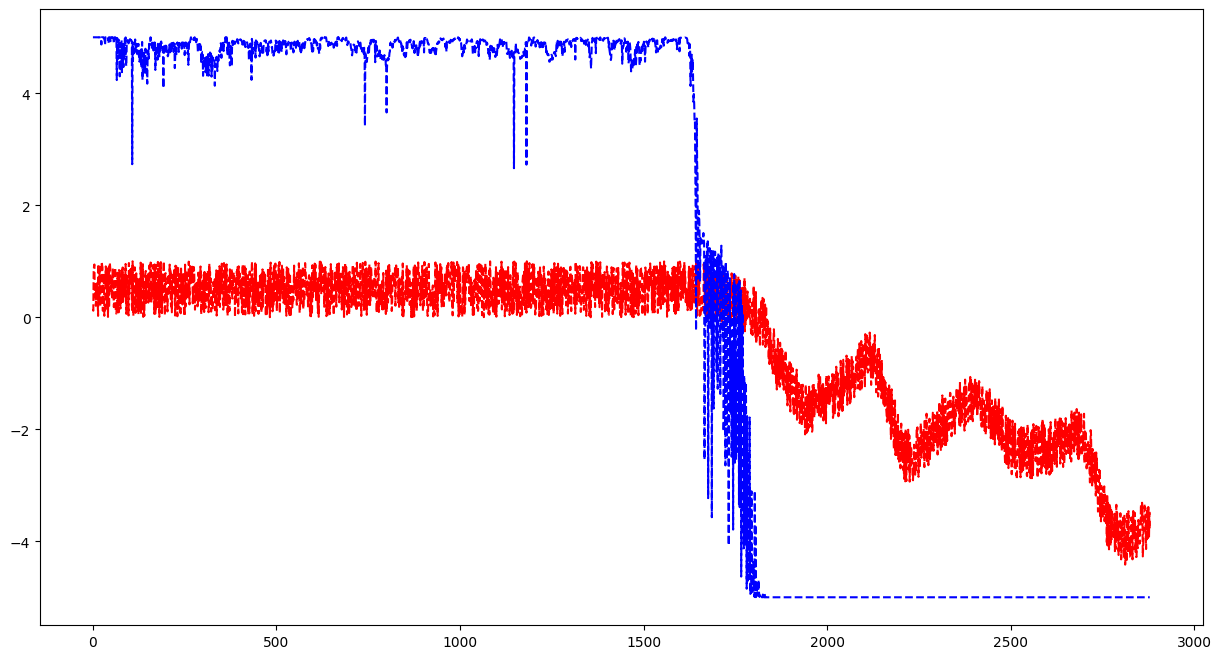

[[1.         0.85802969]
 [0.85802969 1.        ]]


In [3]:
new_traj_reward_list = []
old_traj_reward_list = []
controller = controller_list[building_idx]
out_list = []
cmd_list = []
traj_len = 288*10
for i in range(traj_len):
    state, action, old_reward, kpis, next_state = trajectory[4*i], trajectory[4*i+1], trajectory[4*i+2], trajectory[4*i+3], trajectory[4*i+4]
    # old_reward = reward_func(min_kpis, max_kpis, kpis)
    # print(old_reward, kpis)
    # print('next_state: ', next_state)
    print("action: ", action, "KPI: ", kpis)
    # print("ori next_state: ", env_rl.inverse_transform_state(next_state))
    old_traj_reward_list.append(old_reward)
    with torch.no_grad():
        # tran = np.concatenate((state, action, next_state))
        # model_in = torch.from_numpy(np.array(next_state)).reshape(1, -1).to(torch.float)
        new_reward = reward_function(min_kpis, max_kpis, kpis, next_state)
        new_traj_reward_list.append(new_reward)
    out_list.append(env_rl.inverse_transform_state(next_state))
    cmd_list.append(env_rl.inverse_transform_action(action))
out_df = pd.DataFrame(out_list)
cmd_df = pd.DataFrame(cmd_list)
plt.figure(figsize=(15, 8))
x = list(range(len(old_traj_reward_list)))
plt.plot(x, old_traj_reward_list, 'r--', x, new_traj_reward_list, 'b--')
# plt.plot(new_traj_reward_list, 'b--')
plt.show()
print(np.corrcoef(old_traj_reward_list, new_traj_reward_list))

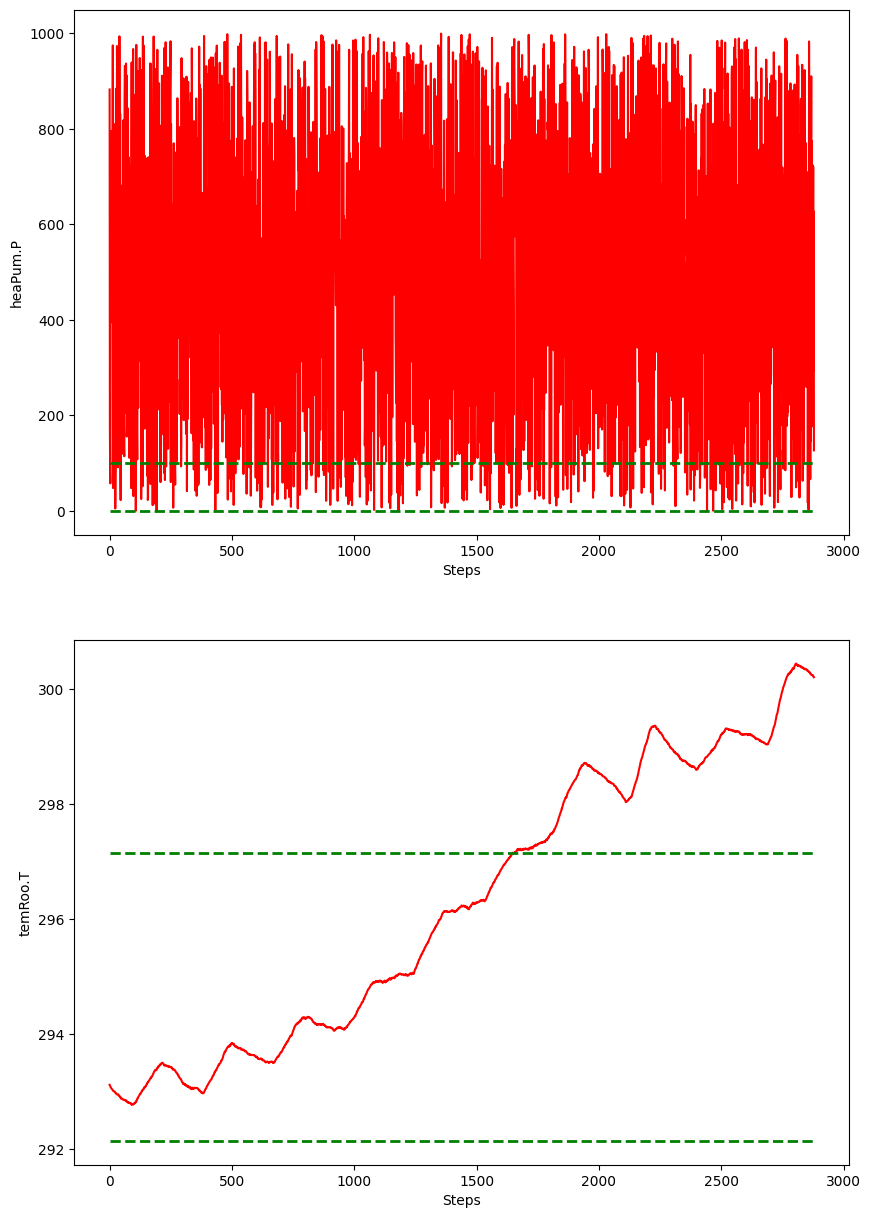

In [4]:
kpi_targets = {}
all_cols_plot = []
for key, val in env_rl.env.kpis.kpi_options.items():
    if "target" in val: kpi_targets[val["name"]] = val["target"]
    if val["name"] not in all_cols_plot: all_cols_plot.append(val["name"])
    
# plot key values
f, axs = plt.subplots(len(all_cols_plot),figsize=(10,15))#
for i, col in enumerate(all_cols_plot):
    axs[i].plot(out_df[col], 'r')
    axs[i].set_ylabel(col)
    axs[i].set_xlabel('Steps')
    if col in kpi_targets: intervals = (kpi_targets[col] if isinstance(kpi_targets[col], list) else [kpi_targets[col], kpi_targets[col]])
    elif env_rl.env.output_specs[col]["type"] == "scalar": intervals = [env_rl.env.output_specs[col]['lower_bound'], env_rl.env.output_specs[col]['upper_bound']]
    else: intervals = [0, 0]
    axs[i].plot([0, out_df.shape[0]], [intervals[0], intervals[0]], color='g', linestyle='--', linewidth=2)
    axs[i].plot([0, out_df.shape[0]], [intervals[1], intervals[1]], color='g', linestyle='--', linewidth=2)
    

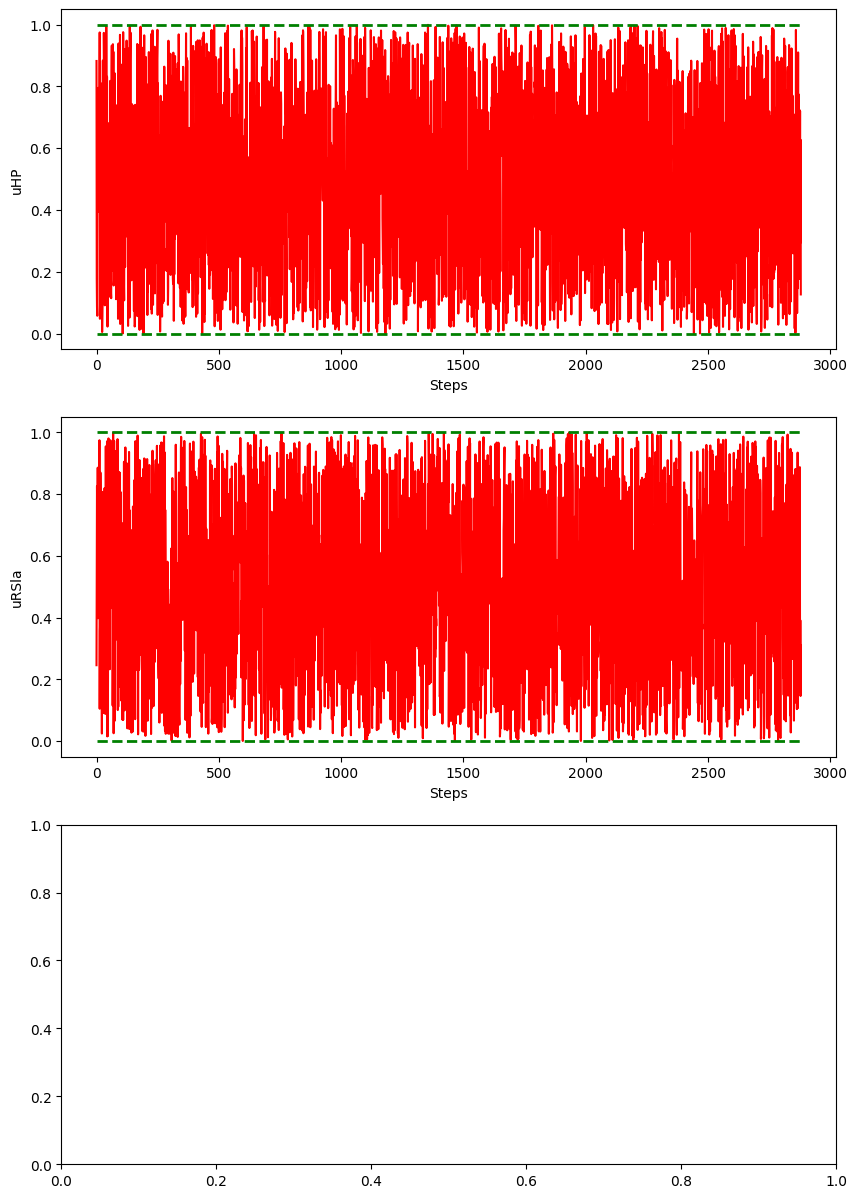

In [5]:
f, axs = plt.subplots(len(inputs)+1,figsize=(10,15))#
for i, col in enumerate(inputs):
    axs[i].plot([x[0] for x in cmd_df[col]], 'r')
    axs[i].set_ylabel(col)
    axs[i].set_xlabel('Steps')
    if env_rl.env.input_specs[col]['type'] == 'scalar':
        intervals = [env_rl.env.input_specs[col]['lower_bound'], env_rl.env.input_specs[col]['upper_bound']]
    else: intervals = [0, 0]
    axs[i].plot([0, cmd_df.shape[0]], [intervals[0], intervals[0]], color='g', linestyle='--', linewidth=2)
    axs[i].plot([0, cmd_df.shape[0]], [intervals[1], intervals[1]], color='g', linestyle='--', linewidth=2)
    

In [6]:
# # Building Name & State Dimensions & Control Dimensions & Num. of Constraints & Main Objective (Minimize) \\
# from energym.wrappers.rl_wrapper import StableBaselinesRLWrapper
# from buildings_factory import *
# objectives = ["average exchanged energy",
#               "average exchanged energy",
#               "average exchanged energy",
#               "average exchanged energy",
#               "power demand",
#               "power demand",
#               "CO2 emission",
#               "CO2 emission",
#               "power demand",
#               "power demand",
#               "power demand",
#               "power demand"]

# model_info = ""
# for building_name in buildings_list:
#     # min_kpis, max_kpis = collect_baseline_kpi(building_name)
#     building_idx = buildings_list.index(building_name)
#     env = get_env(building_name)
#     inputs = get_inputs(building_name, env)
#     default_control = default_controls[building_idx]
#     env_rl = StableBaselinesRLWrapper(building_name, None, None, reward_func)
#     input_dim = env_rl.observation_space.shape[0]
#     control_dim = env_rl.action_space.shape[0]
#     constraint_num = 0
#     for key, val in env.kpi_options.items():
#         if val["type"] == 'avg_dev': constraint_num += 1 
#     main_objective = objectives[building_idx]
#     model_info += f"{building_name} & {input_dim} & {control_dim} & {constraint_num} & {main_objective} \\ "
# print(model_info)

In [7]:
# import pandas as pd
# # buildings_list = ["ApartmentsThermal-v0", "ApartmentsGrid-v0", "Apartments2Thermal-v0",
# #                   "Apartments2Grid-v0", "OfficesThermostat-v0", "MixedUseFanFCU-v0",
# #                   "SeminarcenterThermostat-v0", "SeminarcenterFull-v0", "SimpleHouseRad-v0",
# #                   "SimpleHouseRSla-v0", "SwissHouseRSlaW2W-v0", "SwissHouseRSlaTank-v0"] 

# plot_building_names = ["SwissHouseRSlaW2W-v0", "SwissHouseRSlaTank-v0"]
# seeds = [7, 13, 19, 23]
# # model_names = ["manual_simulator", "manual_predictor", "rewards_simulator", "rewards_predictor"]
# # legend_names = ["Real Env. with Manual Reward Func.", "Learnt Env. with Manual Reward Func.",
# #                 "Real Env. with Learnt Reward Func.", "Learnt Env. with Learnt Reward Func."]
# model_names = ["manual_predictor", "rewards_predictor"]
# legend_names = ["Learnt Env. with Manual Reward Func.",
#                 "Learnt Env. with Learnt Reward Func."]
# # res_cols = ["manual_baseline_eval_episode_reward", "manual_eval_episode_reward",
# #             "baseline_eval_episode_reward", "eval_episode_reward"]
# res_cols = ["manual_baseline_eval_episode_reward", "manual_eval_episode_reward"]
            
# colors = ['r', 'g', 'r--', 'g--']

# res_data = []
# for seed in seeds:
#     for model_name, legend_name in zip(model_names, legend_names):
#         for building in plot_building_names:
#             res_loc = f"data/models/{building}/{model_name}_seed{seed}/logs/best/rewards.csv"
#             res_row = pd.read_csv(res_loc).iloc[-1, :]
#             res_data.append([seed, building, model_name, legend_name,
#                              res_row["eval_episode_reward"], res_row["manual_eval_episode_reward"],
#                              res_row["baseline_eval_episode_reward"], res_row["manual_baseline_eval_episode_reward"]])
# res_df = pd.DataFrame(res_data, columns=["seed", "building", "model_name", 
#                                          "legend", "learnt_reward", "manual_reward",
#                                          "learnt_baseline_reward", "manual_baseline_reward"])
            

# res_df.head()

In [8]:
# import numpy as np
# cols = res_df.columns.tolist()
# # "RL_reward", "manual_RL_reward", "baseline_reward", "manual_baseline_reward"
# cols.remove("seed")
# stat_df = res_df[cols].groupby(["building", "model_name", "legend"]).agg(learnt_reward_mean=("learnt_reward", np.mean),
#                                                            learnt_reward_std=("learnt_reward", np.std),
#                                                            learnt_baseline_reward_mean=("learnt_baseline_reward", np.mean),
#                                                            learnt_baseline_reward_std=("learnt_baseline_reward", np.std),
#                                                            manual_reward_mean=("manual_reward", np.mean),
#                                                            manual_reward_std=("manual_reward", np.std),
#                                                            manual_baseline_reward_mean=("manual_baseline_reward", np.mean),
#                                                            manual_baseline_reward_std=("manual_baseline_reward", np.std)).reset_index()

# stat_df

In [9]:
# import seaborn as sns
# from matplotlib import pyplot as plt
# sns.set_theme(style="ticks", palette="pastel")
# fig, ax = plt.subplots(figsize=(10, 8))

# # Load the example tips dataset
# baseline_reward = res_df.loc[res_df["algorithm"]=="baseline", "reward"].mean()
# res_df_rl = res_df.loc[res_df["algorithm"]=="RL", :]
# # Draw a nested boxplot to show bills by day and time
# fig = sns.boxplot(ax=ax, x="building", y="reward",
#             hue="legend", palette=["m", "g", 'r', 'b'],
#             data=res_df_rl)
# fig.axhline(baseline_reward, linewidth=5.0, label="baseline")
# sns.despine(offset=10, trim=True)